 # Phase 1 - Ingestion and Cleaning

 This notebook carries out the following steps
   1. Ingest data downloaded from the LendingClub website
   2. Choose columns to examine and prepare the data set
   3. Visualizes single variable summaries
   4. Removes outliers
   5. Output a dataset ready for later analysis

 Things for you to add
 - Choose 3 to 5 variables and add them to the list of variables below
 - Try visualizing the new variables and other pairs of variables

 Prepare your presentation. Your presentation should contain at most 6 slides.
 1. Begin by giving an overview of the project. What is the problem you wish to solve, what are the objectives? How will you evaluate the performance of the portfolio you provide? How will you measure success? What are the business KPIs?
 2. What variables did you select for further inspection? Why do you think they will be useful? You may support any argument with a visualization.
 3. List any insight you gained by looking at the data visualization or any other data analysis that you perform.
 4. List 3-5 hypothesis about which variables will be important for analysis, and how they will affect the outcome.
 5. State your conclusions. What is the main idea you wish to convey with the presentation? Do you think the data available will be useful to solve the problem?

In [1]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn


In [2]:
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False


In [3]:
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

 ## Parameters

In [4]:
#You can download the archived data for 2014 from the WayBack machine here: 
# https://web.archive.org/web/20160703081246/https://resources.lendingclub.com/LoanStats3c.csv.zip
# For the 2012-13 data, use https://web.archive.org/web/20160703081246/https://resources.lendingclub.com/LoanStats3b.csv.zip 
# Download both zip files and unzip them.
# Put both these unzipped files in the appropriate folder ("../data" below) before proceeding below.
# The data dictionary is here: https://web.archive.org/web/20200606105339/https://resources.lendingclub.com/LCDataDictionary.xlsx}
dir_data= "/Users/hrishikeshharishkumar/Desktop/Newdata"


 ## Step 1 - Ingestion
 Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [5]:
os.listdir("/Users/hrishikeshharishkumar/Desktop/Newdata")

['LoanStats3c.csv.zip']

In [6]:
from typing import Dict, final
def ingest_files(directory: str) -> Dict:
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    Lending Club, and *only* those files. Thus, we assume the files are zipped
    (pd.read_csv can read zipped files) and we assume the first line
    in each file needs to be skipped. 
    
    Note that this function will read and ingest more than one file and is
    convenient if you want to ingest data for more than one year at a time.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory = directory + "/"
    
    all_files = os.listdir(directory)
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory + i, dtype = str, skiprows = 1,encoding='latin1')
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        #invalid_rows = (output[i].id.apply( lambda x : is_integer(x) == False ))
        #if invalid_rows.sum() > 0:
        #    print("        Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
        #    output[i] = output[i][invalid_rows == False]
    
    return output


In [7]:
# Ingest the set of files we downloaded 
files_data = ingest_files(dir_data)


Directory /Users/hrishikeshharishkumar/Desktop/Newdata/ has 1 files:
    Reading file LoanStats3c.csv.zip


In [8]:
files_data.keys()

dict_keys(['LoanStats3c.csv.zip'])

In [9]:
data_now = pd.concat(files_data.values()).reset_index(drop = True)
columns = list(data_now.columns)
columns

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_

In [10]:
print(data_now.isnull().sum())

id                       235629
member_id                235631
loan_amnt                     2
funded_amnt                   2
funded_amnt_inv               2
                          ...  
settlement_status        231061
settlement_date          231061
settlement_amount        231061
settlement_percentage    231061
settlement_term          231061
Length: 144, dtype: int64


 ## Step 2 - Choose Columns and Prepare Dataset

In [11]:
# Identify the columns we'll be keeping from the dataset

# New Columns to be added:

# bc_util: Ratio of total current balance to high credit/credit limit for all bankcard accounts.
# inq_last_6mths: The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
# pct_tl_nvr_dlq: Percent of trades never delinquent
# total_acc: The total number of credit lines currently in the borrower's credit file
# out_prncp: Remaining outstanding principal for total amount funded
# tot_cur_bal: Total current balance of all accounts
# funded_amnt_inv: The total amount committed by investors for that loan at that point in time.
# sub_grade: LC assigned loan subgrade
# acc_now_delinq: The number of accounts on which the borrower is now delinquent.
# tot_coll_amt: Total collection amounts ever owed


cols_to_pick = ['loan_amnt','funded_amnt','term','int_rate',
                 'installment','grade','emp_length', 'home_ownership',
                 'annual_inc','verification_status','issue_d',
                 'loan_status','purpose','dti', 'delinq_2yrs',
                 'earliest_cr_line','open_acc','pub_rec',
                 'revol_bal','revol_util', 'total_pymnt',
                 'last_pymnt_d', 'recoveries',
            
                'tot_cur_bal','bc_util','funded_amnt_inv',
                'inq_last_6mths', 'pct_tl_nvr_dlq','total_acc', 'tot_coll_amt'
            ]

# Identify the type of each of these column
float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
                     'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
                                'total_pymnt', 'recoveries',
             
                'tot_cur_bal','bc_util','funded_amnt_inv',
                'inq_last_6mths', 'pct_tl_nvr_dlq','total_acc','tot_coll_amt'
                ]

cat_cols = ['term', 'grade', 'emp_length', 'home_ownership',
                    'verification_status', 'loan_status', 'purpose']
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line','last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set()


In [12]:
# Keep only the columns of interest
final_data = data_now[cols_to_pick].copy()


In [13]:
final_data

,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,total_pymnt,last_pymnt_d,recoveries,tot_cur_bal,bc_util,funded_amnt_inv,inq_last_6mths,pct_tl_nvr_dlq,total_acc,tot_coll_amt
0,15000,15000,60 months,12.39%,336.64,C,10+ years,RENT,78000,Source Verified,...,17392.37,Jun-2016,0.0,149140,4.7,15000,0,100,17,0
1,10400,10400,36 months,6.99%,321.08,A,8 years,MORTGAGE,58000,Not Verified,...,6611.69,Aug-2016,521.27,162110,41.5,10400,2,83.3,36,0
2,7650,7650,36 months,13.66%,260.2,C,< 1 year,RENT,50000,Source Verified,...,2281.98,Aug-2015,1237.99,64426,93.2,7650,1,100,20,0
3,12800,12800,60 months,17.14%,319.08,D,10+ years,MORTGAGE,125000,Verified,...,19165.3519248725,Sep-2019,0.0,261815,103.2,12800,0,76.9,13,0
4,21425,21425,60 months,15.59%,516.36,D,6 years,RENT,63800,Source Verified,...,25512.2,May-2016,0.0,42315,97.8,21425,0,91.4,35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235626,20700,20700,60 months,16.99%,514.34,D,7 years,MORTGAGE,46000,Verified,...,30573.2219995232,Apr-2018,0.0,73598,78.6,20700,2,97.6,43,0
235627,2000,2000,36 months,7.90%,62.59,A,3 years,OWN,83000,Verified,...,2126.579837877,Dec-2014,0.0,591610,23.4,2000,1,85.2,27,0
235628,10000,10000,36 months,19.20%,367.58,D,10+ years,MORTGAGE,46000,Verified,...,13232.50333937,Jan-2017,0.0,57477,83.9,9975,0,90.9,22,0
235629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
print("Starting with " + str(len(final_data)) + " rows")


Starting with 235631 rows


In [15]:
final_data.shape

(235631, 30)

In [16]:
duplicate_rows_df = final_data[final_data.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (1, 30)


In [17]:
print(final_data.isnull().sum())

loan_amnt                  2
funded_amnt                2
term                       2
int_rate                   2
installment                2
grade                      2
emp_length             12021
home_ownership             2
annual_inc                 2
verification_status        2
issue_d                    2
loan_status                2
purpose                    2
dti                        2
delinq_2yrs                2
earliest_cr_line           2
open_acc                   2
pub_rec                    2
revol_bal                  2
revol_util               127
total_pymnt                2
last_pymnt_d             145
recoveries                 2
tot_cur_bal                2
bc_util                 2613
funded_amnt_inv            2
inq_last_6mths             2
pct_tl_nvr_dlq             2
total_acc                  2
tot_coll_amt               2
dtype: int64


 # To do (A)

 Choose 3 to 5 variables and add them to the list of variables below

 You should consult the data description (excel) file you downloaded to understand the definition of various available columns

 TIP: If you added new variables, be sure to clean them as we just did for the default variables.

 You will have to add them to the group of the right type of variables (e.g. percentage, date, categorical)


 ### Typecast the columns

In [18]:
for i in float_cols:
    final_data[i] = final_data[i].astype(float)
    
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.rstrip()[:-1])
for i in perc_cols:
    final_data[i] = final_data[i].apply( clean_perc )
    
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()
for i in date_cols:
    final_data[i] = final_data[i].apply( clean_date )
    
for i in cat_cols:
    final_data.loc[final_data[i].isnull(), i] = None


In [19]:
final_data.head()


,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,total_pymnt,last_pymnt_d,recoveries,tot_cur_bal,bc_util,funded_amnt_inv,inq_last_6mths,pct_tl_nvr_dlq,total_acc,tot_coll_amt
0,15000.0,15000.0,60 months,12.39,336.64,C,10+ years,RENT,78000.0,Source Verified,...,17392.370000,2016-06-01,0.00,149140.0,4.7,15000.0,0.0,100.0,17.0,0.0
1,10400.0,10400.0,36 months,6.99,321.08,A,8 years,MORTGAGE,58000.0,Not Verified,...,6611.690000,2016-08-01,521.27,162110.0,41.5,10400.0,2.0,83.3,36.0,0.0
2,7650.0,7650.0,36 months,13.66,260.20,C,< 1 year,RENT,50000.0,Source Verified,...,2281.980000,2015-08-01,1237.99,64426.0,93.2,7650.0,1.0,100.0,20.0,0.0
3,12800.0,12800.0,60 months,17.14,319.08,D,10+ years,MORTGAGE,125000.0,Verified,...,19165.351925,2019-09-01,0.00,261815.0,103.2,12800.0,0.0,76.9,13.0,0.0
4,21425.0,21425.0,60 months,15.59,516.36,D,6 years,RENT,63800.0,Source Verified,...,25512.200000,2016-05-01,0.00,42315.0,97.8,21425.0,0.0,91.4,35.0,0.0


 ## Step 3- Visualize the variables

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
def visualize_columns():
    '''
    This function visualizes all columns
      - Box-and-whisker plots for continuous variables
      - Lists of distinct values for categorical columns
      - A timeline density for dates
    '''
    
    # Float columns
    for i in float_cols + perc_cols:
        # seaborn.boxplot(final_data[i])
        final_data.boxplot(i)

        # Print the three highest values
        highest_vals = sorted(final_data[i], reverse=True)[:3]
        smallest_val = min(final_data[i])
        print("Top 3 Max: ", highest_vals, "\nMin: ", smallest_val)
        # plt.text(smallest_val, -0.3, highest_vals[0])
        # plt.text(smallest_val, -0.2, highest_vals[1])
        # plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()
        
    # Categorical columns 
    for i in cat_cols:
        print(i)
        print(str(len(set(final_data[i]))) + " distinct values")
        print(final_data[i].value_counts())
        print("")
        print("")
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()


<Figure size 400x400 with 0 Axes>

Top 3 Max:  [35000.0, 35000.0, 35000.0] 
Min:  1000.0


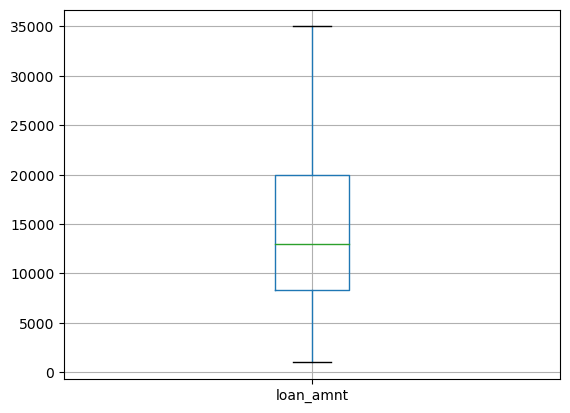

Top 3 Max:  [35000.0, 35000.0, 35000.0] 
Min:  1000.0


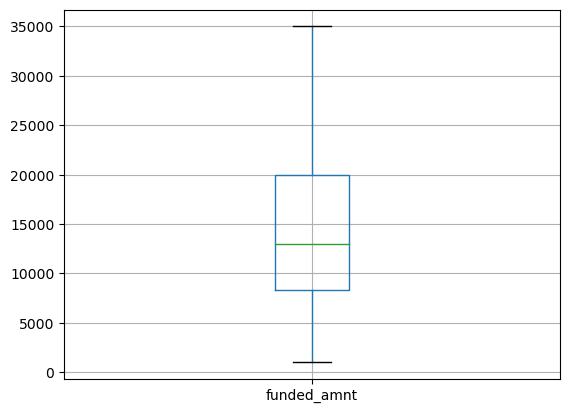

Top 3 Max:  [1409.99, 1409.99, 1408.13] 
Min:  23.36


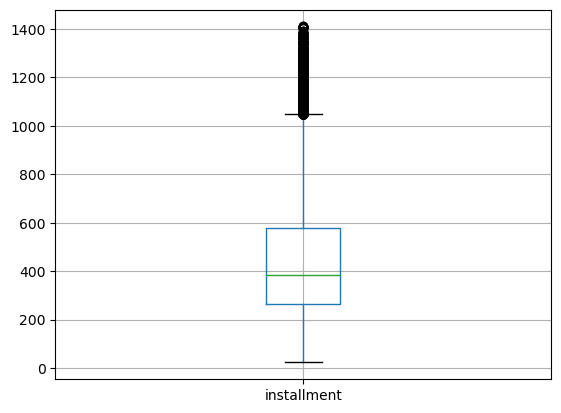

Top 3 Max:  [7500000.0, 7446395.0, 4900000.0] 
Min:  3000.0


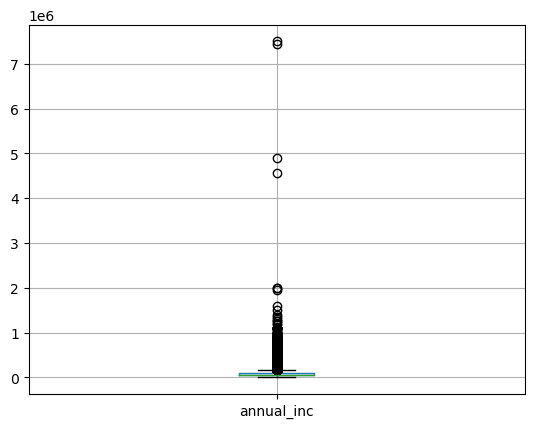

Top 3 Max:  [39.99, 39.99, 39.99] 
Min:  0.0


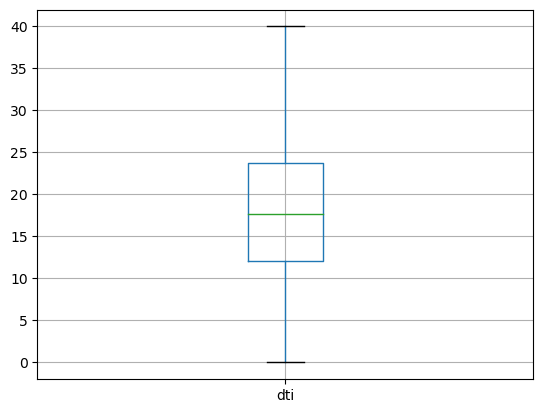

Top 3 Max:  [2560703.0, 1298783.0, 1190046.0] 
Min:  0.0


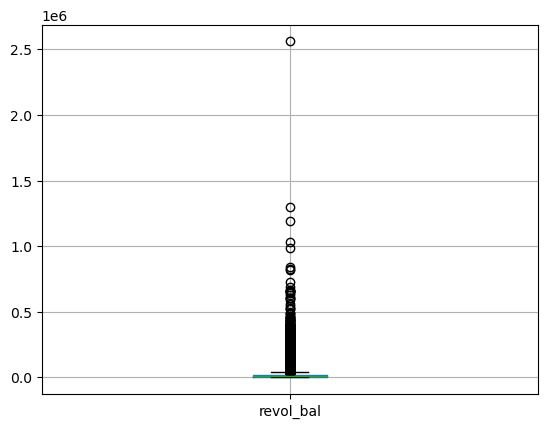

Top 3 Max:  [22.0, 22.0, 21.0] 
Min:  0.0


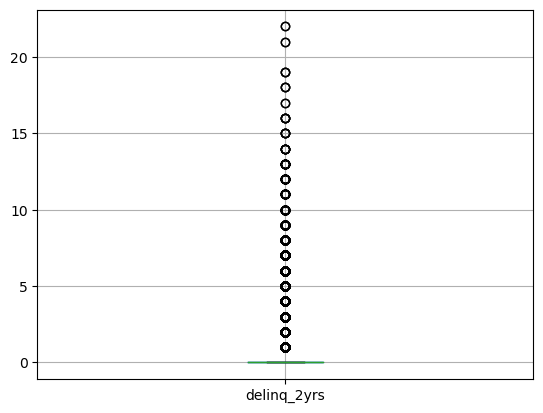

Top 3 Max:  [84.0, 76.0, 76.0] 
Min:  0.0


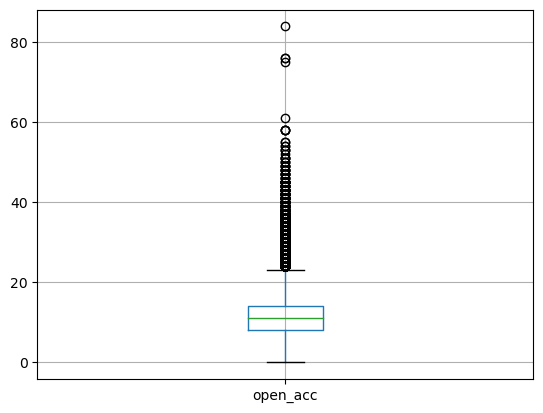

Top 3 Max:  [63.0, 40.0, 34.0] 
Min:  0.0


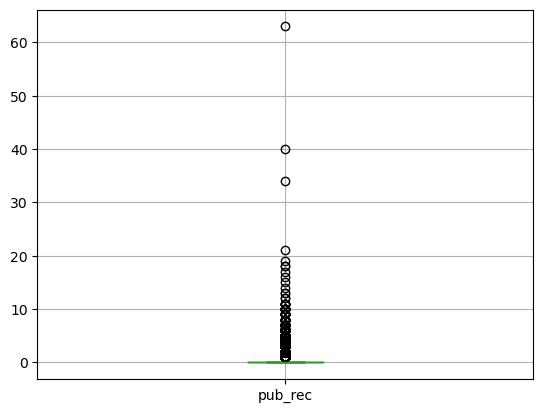

Top 3 Max:  [63296.8779169909, 63175.840068808, 62985.9059066547] 
Min:  0.0


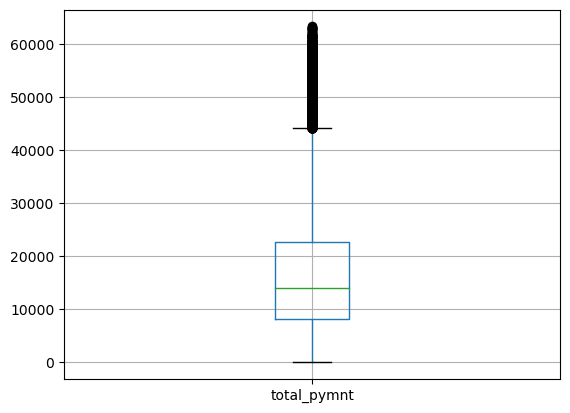

Top 3 Max:  [33389.89, 32321.34, 32226.18] 
Min:  0.0


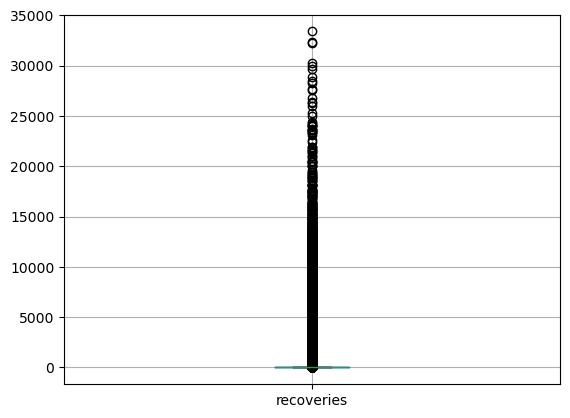

Top 3 Max:  [4026405.0, 3840795.0, 3796811.0] 
Min:  0.0


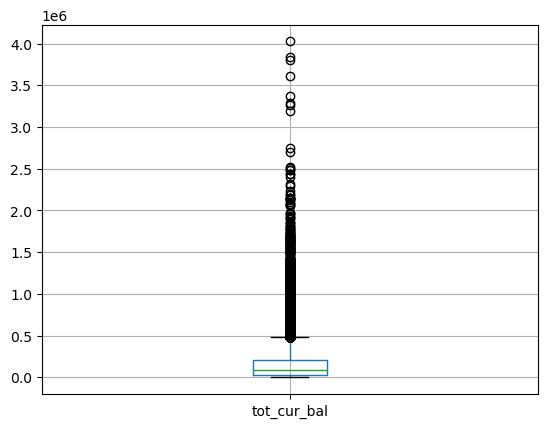

Top 3 Max:  [111.6, 110.3, 108.8] 
Min:  0.0


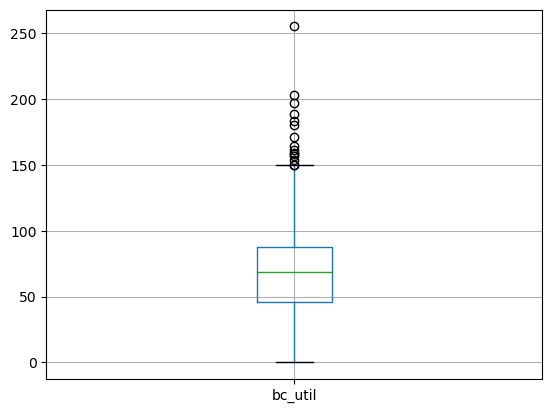

Top 3 Max:  [35000.0, 35000.0, 35000.0] 
Min:  950.0


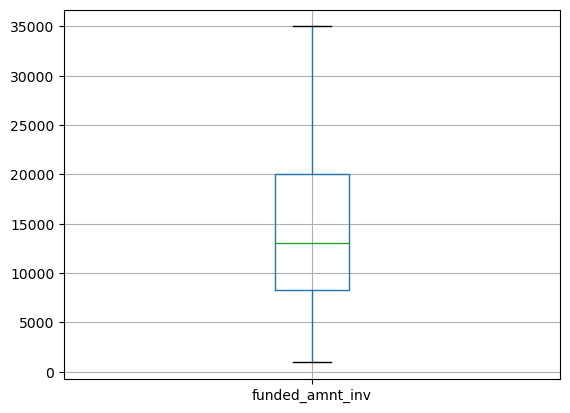

Top 3 Max:  [6.0, 6.0, 6.0] 
Min:  0.0


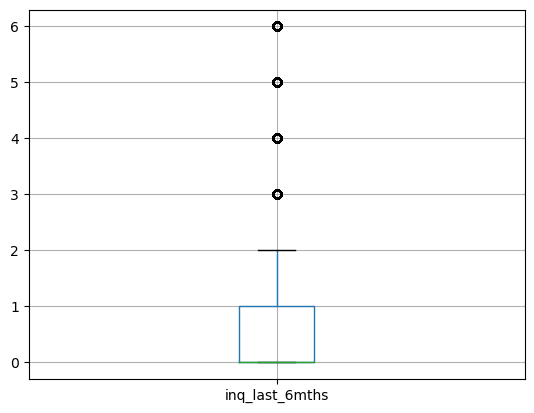

Top 3 Max:  [100.0, 100.0, 100.0] 
Min:  16.7


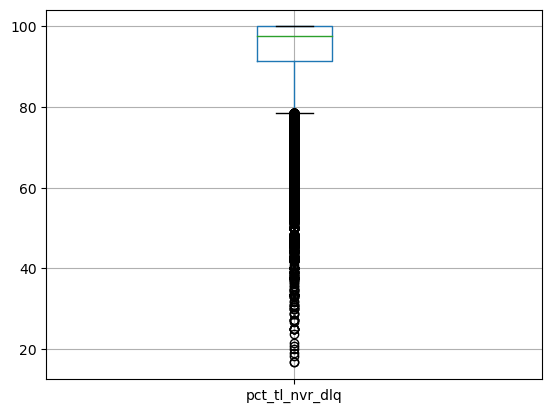

Top 3 Max:  [156.0, 150.0, 124.0] 
Min:  2.0


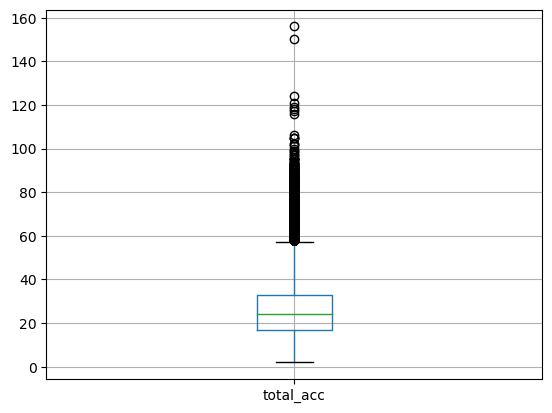

Top 3 Max:  [9152545.0, 296368.0, 126297.0] 
Min:  0.0


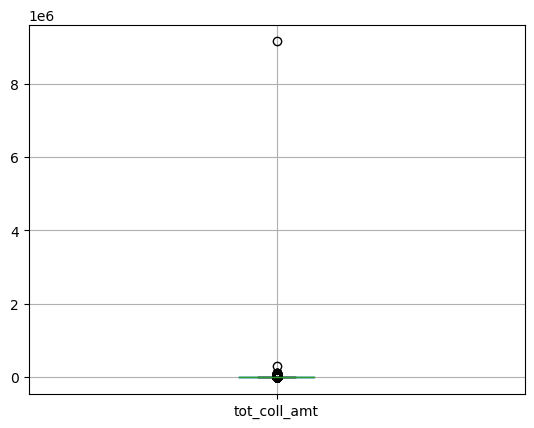

Top 3 Max:  [26.06, 26.06, 26.06] 
Min:  6.0


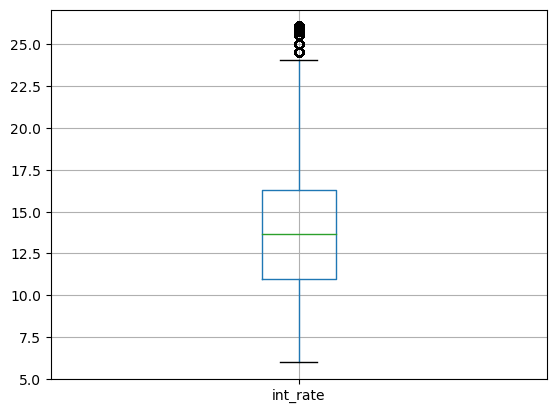

Top 3 Max:  [177.7, 153.0, 129.4] 
Min:  0.0


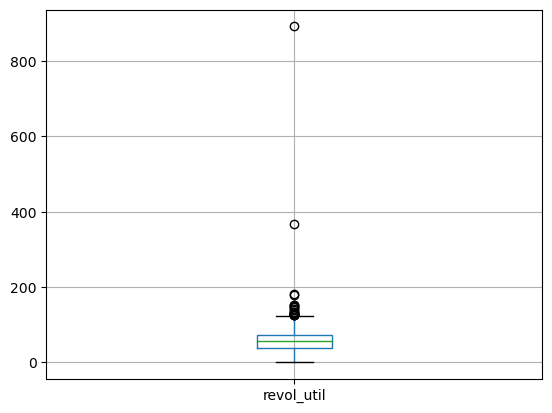

term
3 distinct values
 36 months    162570
 60 months     73059
Name: term, dtype: int64


grade
8 distinct values
C    66565
B    61935
D    42992
A    36108
E    20121
F     6223
G     1685
Name: grade, dtype: int64


emp_length
12 distinct values
10+ years    79505
2 years      20487
3 years      18267
< 1 year     17982
1 year       14593
4 years      13528
7 years      13099
5 years      13051
8 years      11853
6 years      11821
9 years       9424
Name: emp_length, dtype: int64


home_ownership
5 distinct values
MORTGAGE    119937
RENT         92684
OWN          23007
ANY              1
Name: home_ownership, dtype: int64


verification_status
4 distinct values
Source Verified    97741
Not Verified       70659
Verified           67229
Name: verification_status, dtype: int64


loan_status
3 distinct values
Fully Paid     193881
Charged Off     41748
Name: loan_status, dtype: int64


purpose
14 distinct values
debt_consolidation    143006
credit_card            55522
home_improvem

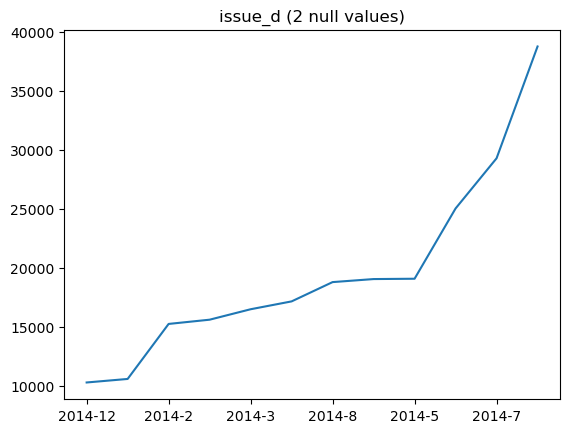

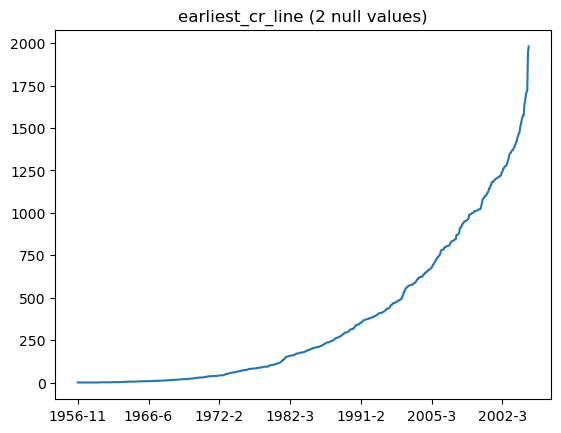

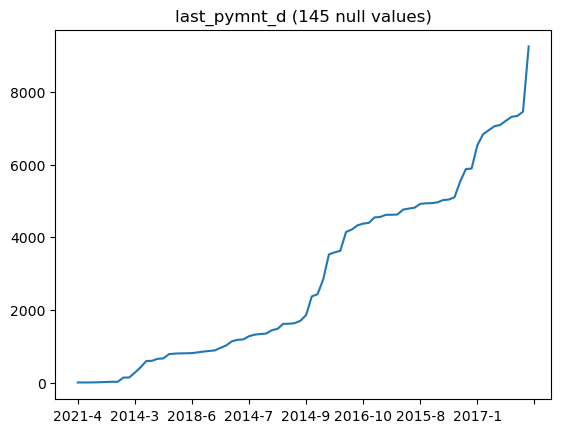

In [21]:
visualize_columns()


 # To do (B)

 Try visualizing the new variables and other pairs of variables


 ## Step 4 - Handle outliers

In [22]:
len(final_data)

235631

In [23]:
# There are quite a few outliers, but the two most obvious
# ones to remove are in annual_inc, revol_bal Remove these.
n_rows = len(final_data)
final_data = final_data[final_data.annual_inc < 500000]
final_data = final_data[final_data.revol_bal < 200000]
#final_data = final_data[final_data.dti < 200]

final_data = final_data[final_data.tot_cur_bal < 500000]
final_data = final_data[final_data.pct_tl_nvr_dlq > 80]
final_data = final_data[final_data.total_acc < 60]
final_data = final_data[final_data.tot_coll_amt < 20000]
print("Removed " + str(n_rows - len(final_data)) + " rows")


Removed 27763 rows


In [24]:
len(final_data)

207868

In [25]:
# Remove all loans that are too recent to have been paid off or
# defaulted
n_rows = len(final_data)
final_data = final_data[final_data.loan_status.isin(['Fully Paid','Charged Off','Default'])]
print("Removed " + str(n_rows - len(final_data)) + " rows")


Removed 0 rows


In [26]:
len(final_data)

207868

In [27]:
# Only include loans issued since 2009
n_rows = len(final_data)
final_data = final_data[final_data.issue_d >= datetime.date(2009, 1, 1)]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 0 rows


Top 3 Max:  [35000.0, 35000.0, 35000.0] 
Min:  1000.0


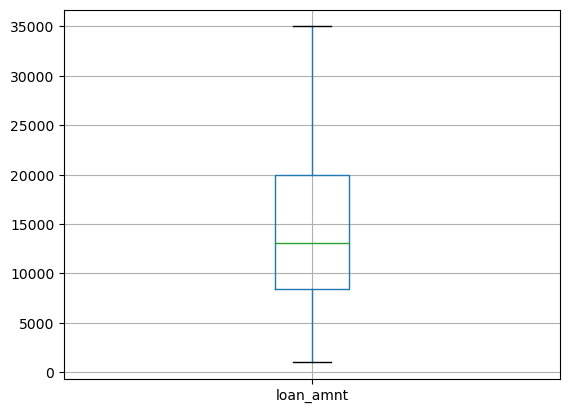

Top 3 Max:  [35000.0, 35000.0, 35000.0] 
Min:  1000.0


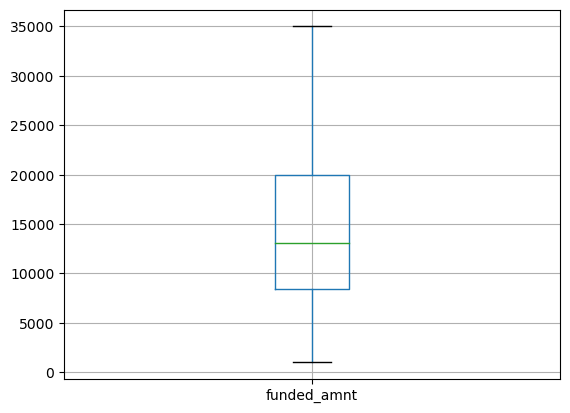

Top 3 Max:  [1409.99, 1409.99, 1408.13] 
Min:  23.36


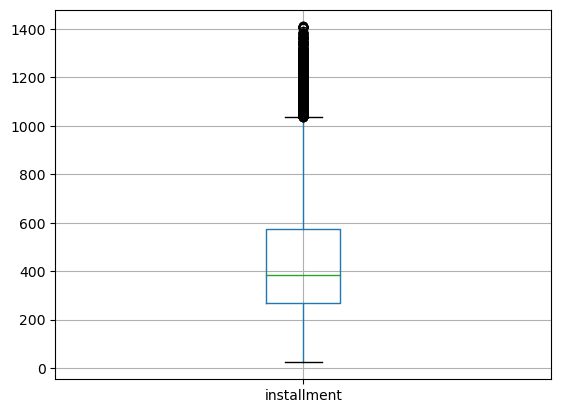

Top 3 Max:  [495000.0, 490000.0, 485000.0] 
Min:  3000.0


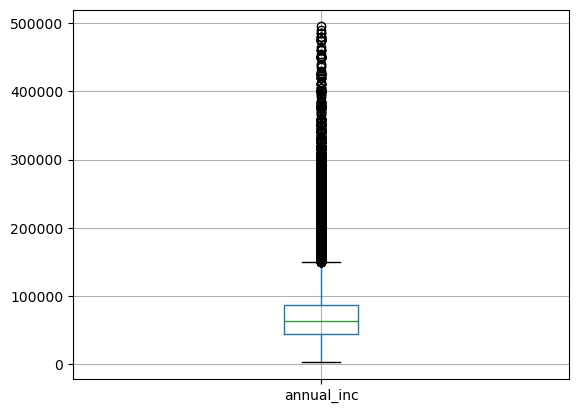

Top 3 Max:  [39.99, 39.99, 39.99] 
Min:  0.0


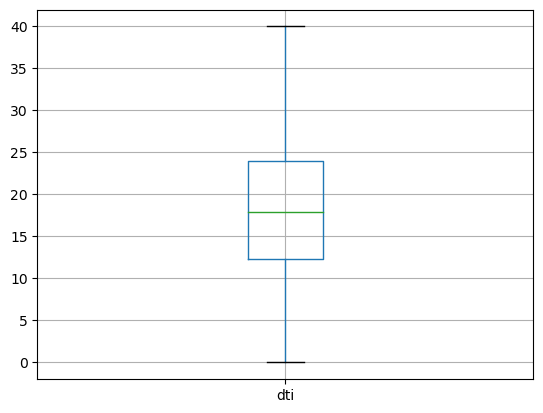

Top 3 Max:  [199697.0, 198278.0, 197537.0] 
Min:  0.0


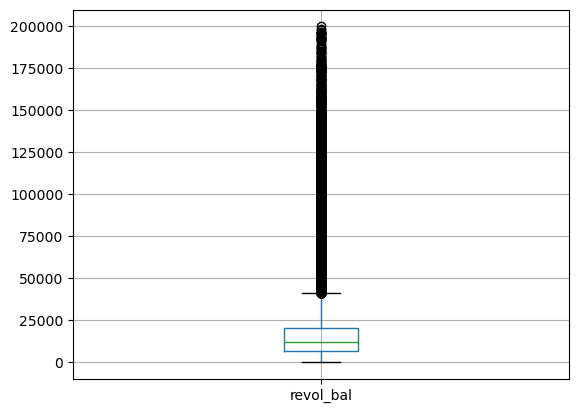

Top 3 Max:  [13.0, 11.0, 10.0] 
Min:  0.0


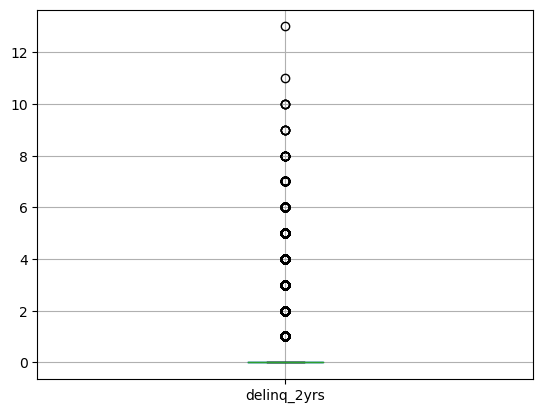

Top 3 Max:  [49.0, 48.0, 46.0] 
Min:  0.0


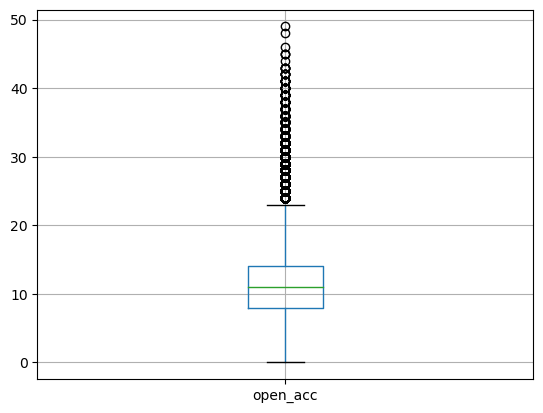

Top 3 Max:  [63.0, 40.0, 34.0] 
Min:  0.0


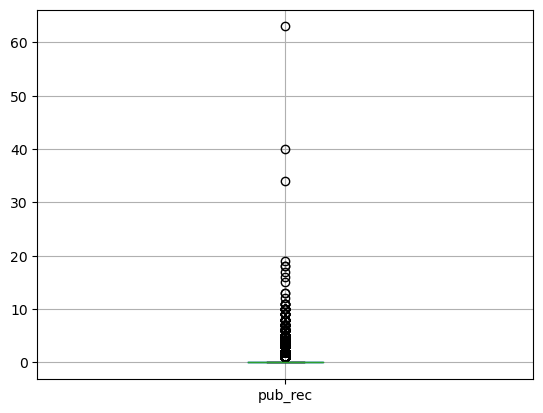

Top 3 Max:  [63296.8779169909, 63175.840068808, 62948.9909562492] 
Min:  0.0


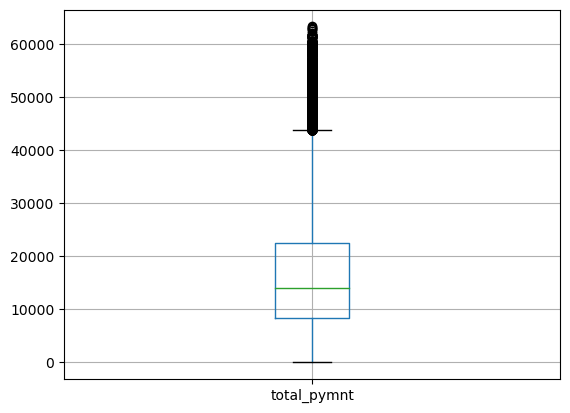

Top 3 Max:  [33389.89, 32321.34, 32226.18] 
Min:  0.0


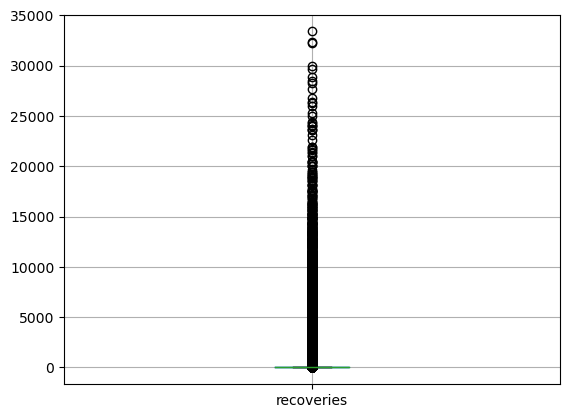

Top 3 Max:  [499948.0, 499936.0, 499909.0] 
Min:  0.0


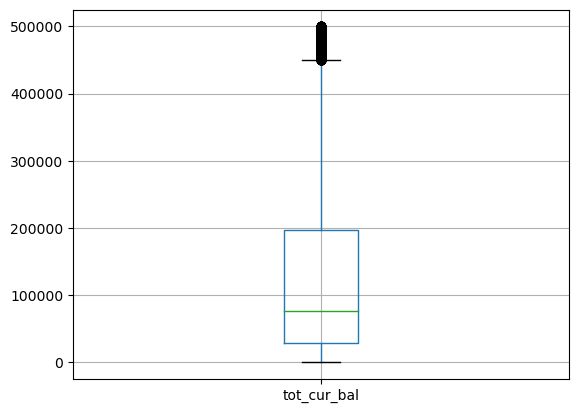

Top 3 Max:  [113.5, 104.4, 104.1] 
Min:  0.0


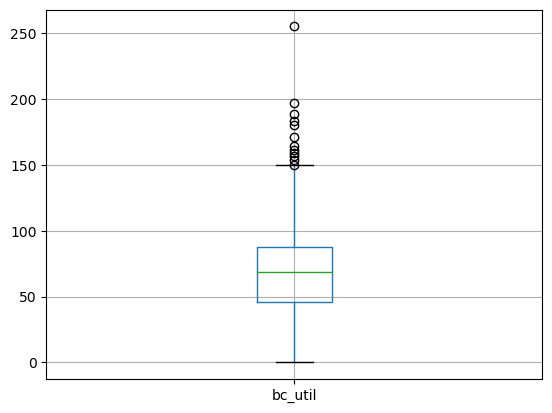

Top 3 Max:  [35000.0, 35000.0, 35000.0] 
Min:  950.0


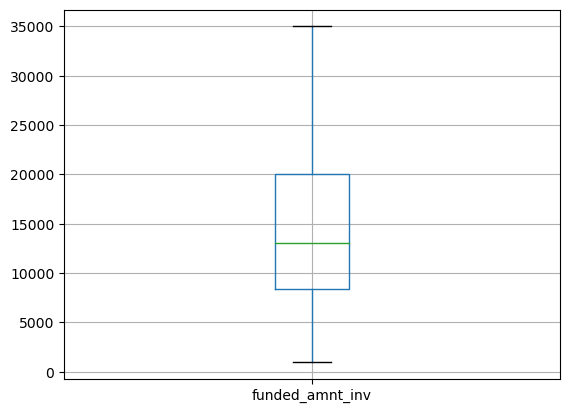

Top 3 Max:  [6.0, 6.0, 6.0] 
Min:  0.0


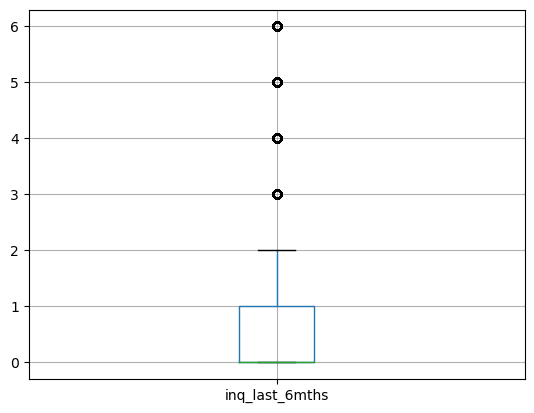

Top 3 Max:  [100.0, 100.0, 100.0] 
Min:  80.4


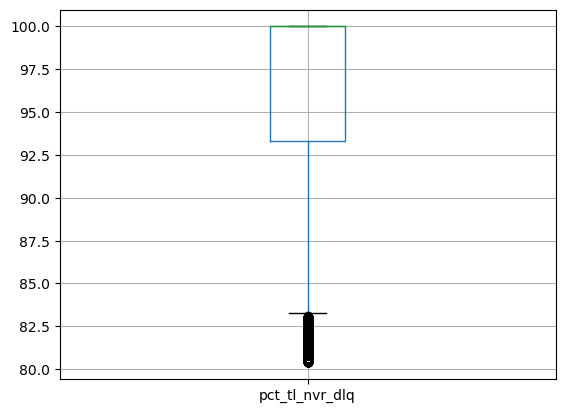

Top 3 Max:  [59.0, 59.0, 59.0] 
Min:  2.0


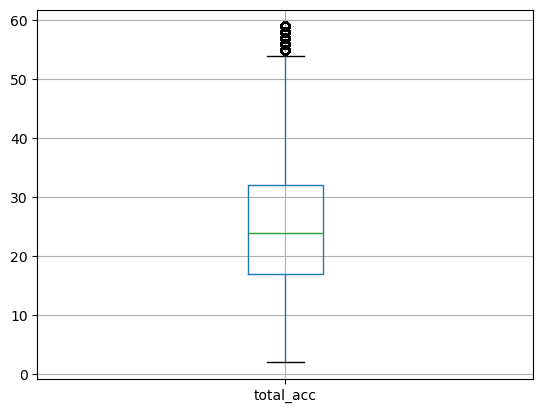

Top 3 Max:  [19906.0, 19906.0, 19815.0] 
Min:  0.0


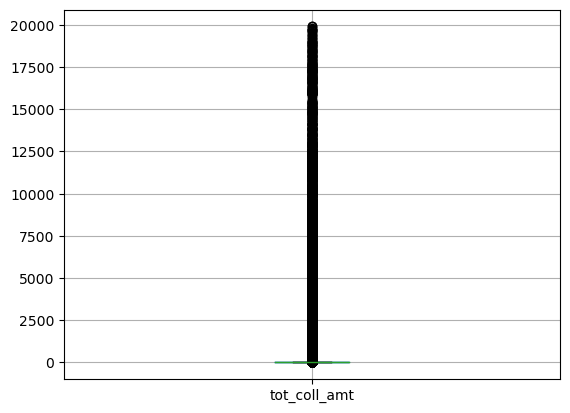

Top 3 Max:  [26.06, 26.06, 26.06] 
Min:  6.0


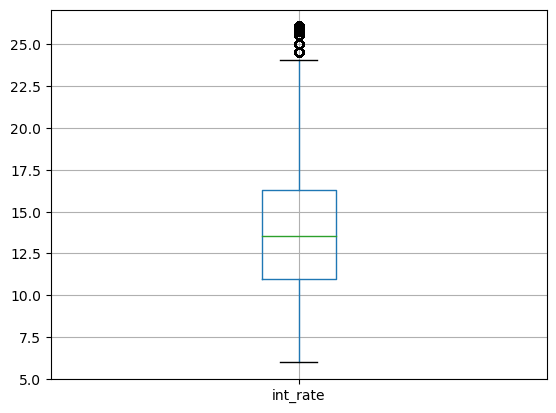

Top 3 Max:  [180.3, 134.3, 130.2] 
Min:  0.0


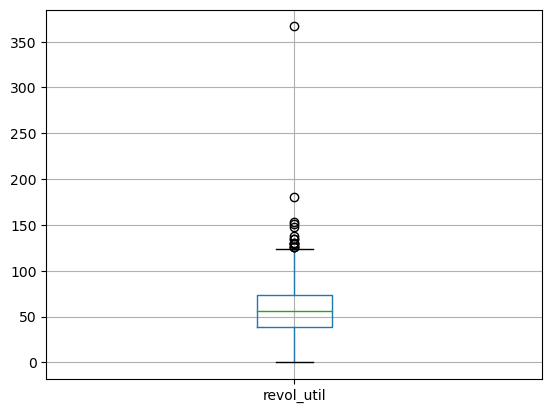

term
2 distinct values
 36 months    142644
 60 months     65224
Name: term, dtype: int64


grade
7 distinct values
C    57872
B    54661
D    37776
A    32902
E    17701
F     5461
G     1495
Name: grade, dtype: int64


emp_length
12 distinct values
10+ years    69072
2 years      18214
3 years      16176
< 1 year     16086
1 year       13018
4 years      12028
7 years      11659
5 years      11570
8 years      10530
6 years      10471
9 years       8345
Name: emp_length, dtype: int64


home_ownership
4 distinct values
MORTGAGE    103346
RENT         84210
OWN          20311
ANY              1
Name: home_ownership, dtype: int64


verification_status
3 distinct values
Source Verified    87393
Not Verified       62291
Verified           58184
Name: verification_status, dtype: int64


loan_status
2 distinct values
Fully Paid     170579
Charged Off     37289
Name: loan_status, dtype: int64


purpose
13 distinct values
debt_consolidation    126663
credit_card            50126
home_improvem

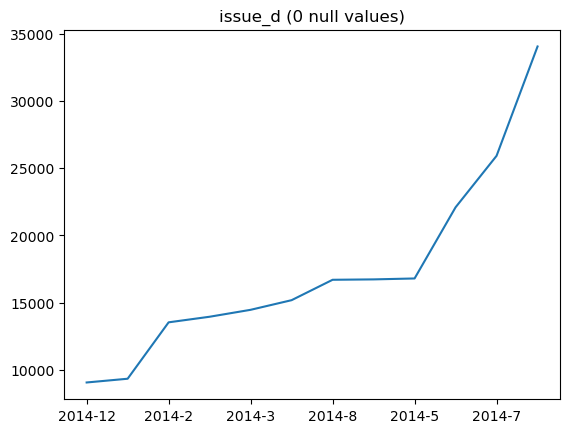

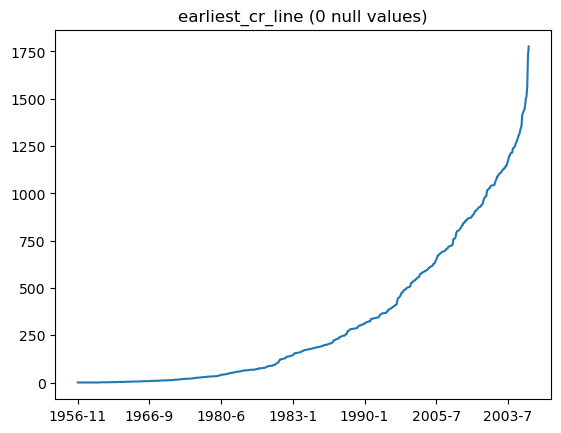

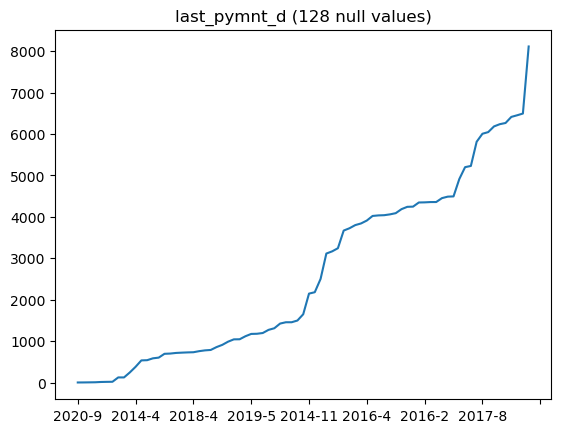

In [28]:
# Visualize the data again
visualize_columns()

 ### Drop null values

In [29]:
# Deal with null values. We allow categorical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement
required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)
final_data.dropna(subset = required_cols ,inplace=True)
print("Removed " + str(n_rows - len(final_data)) + " rows")


Removed 2230 rows


In [30]:
len(final_data)

205638

In [31]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features
discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)


 ## Step 5 - Save a Pickle

In [32]:
# Remove the total_pymnt from the list of continuous features; this
# variable is highly predictive of the outcome but is not known at
# the time the loan is issued
continuous_features = [i for i in continuous_features if i not in ["total_pymnt", "recoveries"]]


In [33]:
# Define the output path for the pickle
pickle_file = "/".join(['.', "PickleData", "clean_data_Sep28.pickle"])
os.makedirs(os.path.dirname(pickle_file), exist_ok=True)
pickle.dump( [final_data, discrete_features, continuous_features], open(pickle_file, "wb") )


In [34]:
final_data.head()


,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,total_pymnt,last_pymnt_d,recoveries,tot_cur_bal,bc_util,funded_amnt_inv,inq_last_6mths,pct_tl_nvr_dlq,total_acc,tot_coll_amt
0,15000.0,15000.0,60 months,12.39,336.64,C,10+ years,RENT,78000.0,Source Verified,...,17392.37,2016-06-01,0.00,149140.0,4.7,15000.0,0.0,100.0,17.0,0.0
1,10400.0,10400.0,36 months,6.99,321.08,A,8 years,MORTGAGE,58000.0,Not Verified,...,6611.69,2016-08-01,521.27,162110.0,41.5,10400.0,2.0,83.3,36.0,0.0
2,7650.0,7650.0,36 months,13.66,260.20,C,< 1 year,RENT,50000.0,Source Verified,...,2281.98,2015-08-01,1237.99,64426.0,93.2,7650.0,1.0,100.0,20.0,0.0
4,21425.0,21425.0,60 months,15.59,516.36,D,6 years,RENT,63800.0,Source Verified,...,25512.20,2016-05-01,0.00,42315.0,97.8,21425.0,0.0,91.4,35.0,0.0
5,9600.0,9600.0,36 months,13.66,326.53,C,10+ years,RENT,69000.0,Source Verified,...,9973.43,2015-04-01,0.00,38566.0,69.2,9600.0,0.0,100.0,44.0,0.0


 ## Read from Pickle if Saved
 Read data from saved pickle files

In [35]:
### Read the data and features from the pickle
final_data, discrete_features, continuous_features = pickle.load( open( "./PickleData/clean_data_Sep28.pickle", "rb" ) )
#final_data, discrete_features, continuous_features = pickle.load( open( "./PickleData/201213clean_data.pickle", "rb" ) )


In [36]:
len(final_data)

205638

 ## Step 6 Prepare your presentation.

 Your presentation should contain at most 6 slides.

 1) Begin by giving an overview of the project. What is the problem you wish to solve, what are the objectives?

 How will you evaluate the performance of the portfolio you provide? How will you measure success?

 What are the business KPIs?

 2) What variables did you select for further inspection? Why do you think they will be useful?

 You may support any argument with a visualization.

 3) List any insight you gained by looking at the data visualization or any other data analysis that you perform.

 4) List 3-5 hypothesis about which variables will be important for analysis, and how they will affect the outcome.

 5) State your conclusions. What is the main idea you wish to convey with the presentation? Do you think the data available will be useful to solve the problem?


## Assigning a target variable - "Default"

In [37]:
final_data['loan_status'].value_counts()

Fully Paid     168879
Charged Off     36759
Name: loan_status, dtype: int64

In [38]:
final_data['Default'] = final_data['loan_status'].apply(lambda x: 0 if x in ['Fully Paid'] else 1)


In [39]:
#plt.figure(figsize=(5,3))
#plt.scatter(final_data['loan_status'],final_data['funded_amnt'], marker='o');
#plt.xlabel('loan_status')
#plt.ylabel('funded_amnt')
#plt.title('funded_amnt vs loan_status')

## Correlation Coefficient of newly added Features 

In [40]:
df = final_data[['tot_cur_bal','bc_util','funded_amnt_inv',
                'inq_last_6mths', 'pct_tl_nvr_dlq','total_acc','tot_coll_amt'
               ]].copy()

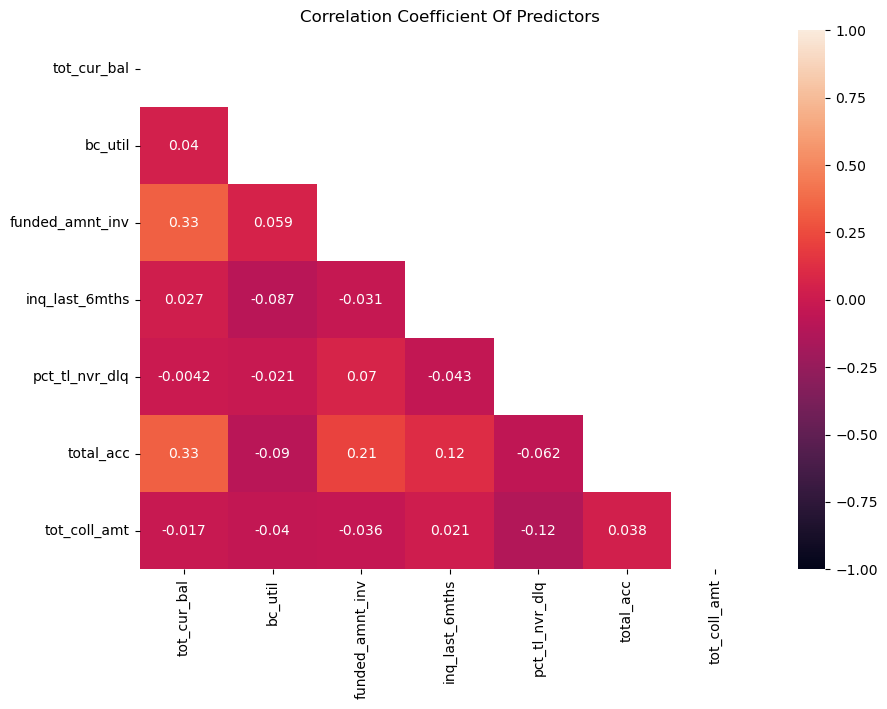

In [41]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))

mask = np.triu(np.ones_like(df.corr(), dtype=bool))

sns.heatmap(df.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

## Correlation Coefficient of all Predictors

In [42]:
final_data_new = final_data.copy()
final_data_new.grade.value_counts()

C    57238
B    54158
D    37313
A    32680
E    17414
F     5363
G     1472
Name: grade, dtype: int64

In [43]:
def condition(x):
    if x=='A':
        return 1
    elif x=='B':
        return 2
    elif x=='C':
        return 3
    elif x=='D':
        return 4
    elif x=='E':
        return 5
    elif x=='F':
        return 6
    else:
        return 7
 
# Applying the conditions
final_data_new['grade_new'] = final_data_new['grade'].apply(condition)

In [44]:
final_data_new.grade_new.value_counts()

3    57238
2    54158
4    37313
1    32680
5    17414
6     5363
7     1472
Name: grade_new, dtype: int64

In [45]:
final_data_new

,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,recoveries,tot_cur_bal,bc_util,funded_amnt_inv,inq_last_6mths,pct_tl_nvr_dlq,total_acc,tot_coll_amt,Default,grade_new
0,15000.0,15000.0,60 months,12.39,336.64,C,10+ years,RENT,78000.0,Source Verified,...,0.00,149140.0,4.7,15000.0,0.0,100.0,17.0,0.0,0,3
1,10400.0,10400.0,36 months,6.99,321.08,A,8 years,MORTGAGE,58000.0,Not Verified,...,521.27,162110.0,41.5,10400.0,2.0,83.3,36.0,0.0,1,1
2,7650.0,7650.0,36 months,13.66,260.20,C,< 1 year,RENT,50000.0,Source Verified,...,1237.99,64426.0,93.2,7650.0,1.0,100.0,20.0,0.0,1,3
4,21425.0,21425.0,60 months,15.59,516.36,D,6 years,RENT,63800.0,Source Verified,...,0.00,42315.0,97.8,21425.0,0.0,91.4,35.0,0.0,0,4
5,9600.0,9600.0,36 months,13.66,326.53,C,10+ years,RENT,69000.0,Source Verified,...,0.00,38566.0,69.2,9600.0,0.0,100.0,44.0,0.0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235622,15000.0,15000.0,36 months,13.53,509.25,B,4 years,RENT,66000.0,Source Verified,...,0.00,20140.0,96.5,15000.0,0.0,100.0,20.0,0.0,0,2
235624,18400.0,18400.0,60 months,14.47,432.64,C,4 years,MORTGAGE,110000.0,Source Verified,...,0.00,294998.0,89.6,18400.0,2.0,100.0,36.0,0.0,0,3
235625,22000.0,22000.0,60 months,19.97,582.50,D,10+ years,MORTGAGE,78000.0,Verified,...,2.08,221830.0,54.4,22000.0,5.0,100.0,30.0,0.0,1,4
235626,20700.0,20700.0,60 months,16.99,514.34,D,7 years,MORTGAGE,46000.0,Verified,...,0.00,73598.0,78.6,20700.0,2.0,97.6,43.0,0.0,0,4


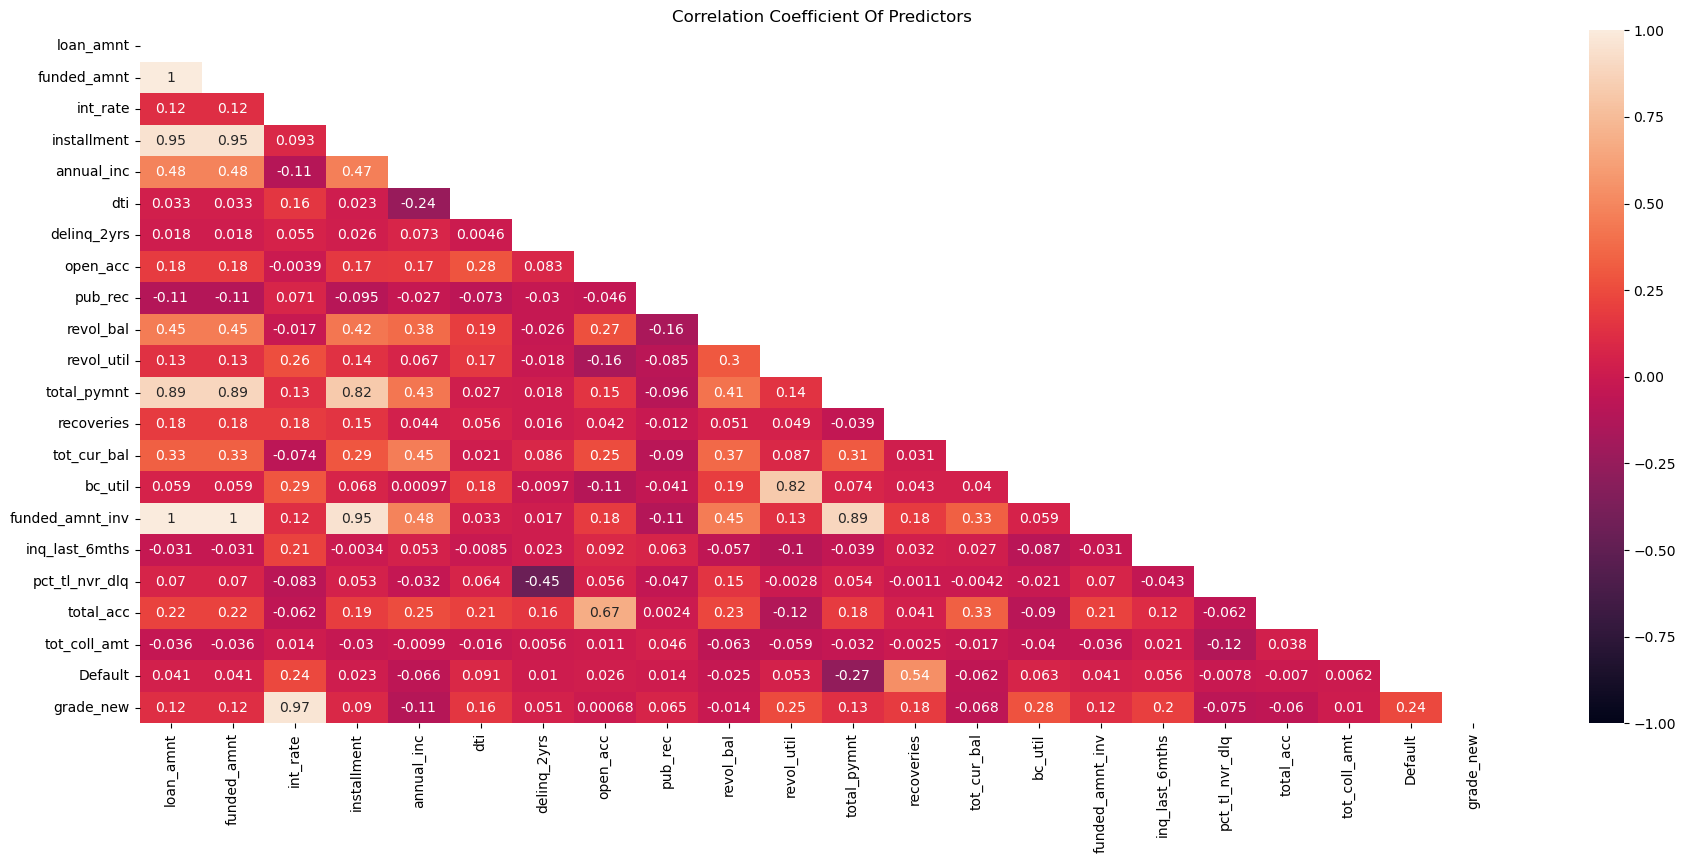

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(22,9))

mask = np.triu(np.ones_like(final_data_new.corr(), dtype=bool))

sns.heatmap(final_data_new.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()